In [1]:
from ipywidgets import interact, IntSlider
import sys
%pylab inline
import matplotlib
matplotlib.rcParams['font.size'] = 14

Populating the interactive namespace from numpy and matplotlib


# DC resistivity example: Gradient array with single source

## Purpose

- Explore the basic setup and physics of a direct current (DC) resistivity survey within the context of kimberlite exploration. 

- Run DC forward modelling and inversion using the SimPEG-Static package. 

## Setup

Physical behavior of DC resistivity survey is governed by steady-state maxwell's equation:

$$\vec{j} = \sigma \vec{e}$$

$$\vec{e} = -\nabla \phi$$

$$\nabla \cdot \vec{j} = -\vec{j}_s = I_0 (\delta(\vec{r}-\vec{r}_+)-\delta(\vec{r}-\vec{r}_-))$$

$$\vec{j} \cdot \hat{n} \ \Big|_{\partial \Omega} = 0$$ 

- $\vec{j}$: Current density (A/m $^2$)

- $\vec{e}$: Electric field (V/m)

- $I_0$: Current (A)

- $\delta$: Volumetric delta function (m $^{-3}$)

Consider a simple gradient array having a pair of A (+) and B (+) current electrodes as the transmitter (Tx) with multiple M (+) and N (-) potential electrode pairs for receivers (Rx). Using a current source (large battery or generator), we setup a significant potential difference between the A and B electrodes which allows electrial currents to flow from the A to B electrode. The presence of conductive or resistive structures within the earth distorts current flow and leads to the accumulation of charges on interfaces. The potential differences measured at each M and N electrode pair will be reflective on those chrage accumulations and current distortions. Forward modelling is the process by which we caluclate the potentials (or associated fields) that would result from a given conductivity model. Conversely, with the inverse problem we reconstruct the model from the observed data. Details regarding the forward modelling and inversion can be found ... (link to EM geosci??????).


Using a DC resitivity survey for diamond or mineral exploration is possible anytime that there is a suiteably large contrast in conductivity between the target and host/background rock. In this example, the kimberlite doposits (which incorporate diamonds) are more conductive than the granitic background rock.

<img src="./DCIP_Diamond.png" width=500> </img>

## Forward problem

### Setup mesh, load model, design survey, and forward model data
- Forward modelling script: https://github.com/simpeg/tutorials/blob/DCIP/notebooks/dcip/TKCExample_DCIPfwd.py

In [15]:
run TKCExample_DCfwd.py

### Visualize synthetic conductivity model: $\sigma (x, y, z)$

(<matplotlib.axes._subplots.AxesSubplot at 0x11695b2d0>,
 (<matplotlib.collections.QuadMesh at 0x1152cd710>,))

<function __main__.<lambda>>

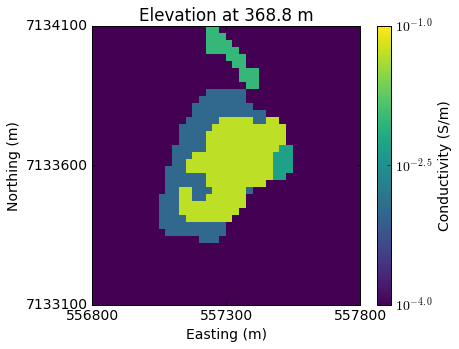

In [16]:
interact(lambda indz: viz(mesh, sigma, indz, airind=airind, normal="Z", xc=xc,yc=yc,zc=zc), indz=IntSlider(min=0, max=mesh.nCz-1,step=1, value=28))

(<matplotlib.axes._subplots.AxesSubplot at 0x115c9b2d0>,
 (<matplotlib.collections.QuadMesh at 0x116a0d390>,))

<function __main__.<lambda>>

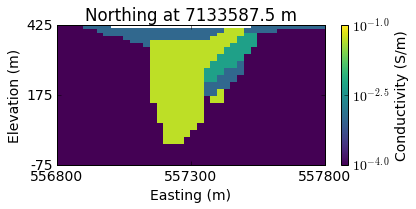

In [17]:
interact(lambda indy: viz(mesh, sigma, indy, airind=airind, normal="Y", xc=xc,yc=yc,zc=zc), indy=IntSlider(min=0, max=mesh.nCy-1,step=1, value=30))

### View electrode geometry for Gradient arrray
This simple survey is comprised of a single Tx electrode pair (A and B electrodes) with 552 associated Rx electrode pairs (M and N). 

- A and B electrode are separeted by 1200m in the E-W direction.
- M and N electrodes have 50m sepatation distances and are also oriented in the E-W direction.

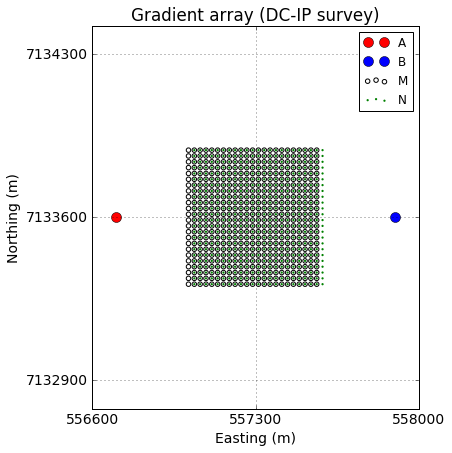

In [18]:
fig, ax = plt.subplots(1,1, figsize=(5*1.3,5*1.3))
plt.xlabel("Easting (m)"); plt.ylabel("Northing (m)")
ax.plot(Aloc1_x[0], Aloc1_x[1], 'ro', ms=10)
ax.plot(Bloc1_x[0], Bloc1_x[1], 'bo', ms=10)
ax.scatter(Mx[:,0], Mx[:,1],s=20, edgecolors="k", facecolors="none")
ax.scatter(Nx[:,0], Nx[:,1],s=5, edgecolors="none", facecolors="g")
ax.legend(("A", "B", "M", "N"), fontsize=12)
xmin, xmax = -700+xc, 700+xc
ymin, ymax = -700+yc, 700+yc
ax.set_xticks(np.linspace(xmin, xmax, 3))
ax.set_yticks(np.linspace(ymin, ymax, 3))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.axis('equal')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_title("Gradient array (DC-IP survey)")
ax.grid(True)
plt.tight_layout()
# fig.savefig("./images/GradientArray", dpi=400)

### Plot computed currents, charges, and secondary potentials

Using a finite volume discretization it is possible to numerically model the potential at any point on the mesh. With the relations below it is also possible to compute and visualize current density, charge distributions, and secondary potentials. These plots can be used to gain a better phyiscal understanding of how currents channel in conductive structures and accuulated charges on the interfaces produce secondary potentials. Since structures with varying conductivity from the background alter the total potentials we can use these measurements to reconstruct a conductivity model.      

- Current density: $\mathbf{j} = \sigma \mathbf{e} = -\sigma \nabla \phi$


- Charge:  $\int_V \epsilon_0 \nabla \cdot \mathbf{e} \  dV = \int_V\rho_v dV$ 
 - where $\rho_v$: Volumetric charge density (C/m $^3$), $\epsilon_0$: Dielectric constant in free-space (F/m)


- Secondary potential: $\phi_s = \phi-\phi_0$
 - where $\phi = F[\sigma]$ , $\phi_0 = F[\sigma_{halfspace}]$

In [19]:
def dataPanelPlot(indz,indy):
    fig = plt.figure(figsize(11, 8))
    Imin, Imax = 2.8e-8,2.7e-5
    Qmin, Qmax =  -18e-11, 3.0e-10
    Vsmin, Vsmax = -2., 2.
    dI, dQ, dV = (Imax-Imin)*0.2, (Qmax-Qmin)*0.2, (Vsmax-Vsmin)*0.2
    xmin, xmax = -700+xc, 700+xc
    ymin, ymax = -700+yc, 700+yc
    zmin, zmax = -700+zc, 0+zc
#     indz = 28
#     indy = 31
    matplotlib.rcParams['font.size'] = 10
    # Axis label
    x = np.linspace(xmin+200, xmax-200,3)

    # Currents z-section
    ax1 = plt.subplot(1,1,1)
    pos =  ax1.get_position()
    ax1.set_position([pos.x0-0.1, pos.y0+0.3,  pos.width*0.5, pos.height*0.5])
    ax1,dat1 = vizEJ(mesh, sigma, indz, f=f, airind=airind, src=src1, normal="Z", ftype="J", xc=xc, yc=yc, zc=zc, clim=(Imin, Imax), ax=ax1, cb=False)
    ax1.plot(Aloc1_x[0], Aloc1_x[1], 'ro', ms=8)
    ax1.plot(Bloc1_x[0], Bloc1_x[1], 'bo', ms=8)
    plt.gca().set_aspect('equal')
    ax1.set_title(("Slice at z=%.1f m")%(mesh.vectorCCz[indz]))
    ax1.xaxis.set_visible(False)
    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(ymin, ymax)
    ax1.set_ylabel('Northing (m)')

    # Cuurents y-section
    pos =  ax1.get_position()
    ax2 = fig.add_axes([pos.x0+0.0525, pos.y0 - 0.36,  pos.width*0.725, pos.height])
    ax2, dat2 = vizEJ(mesh, sigma, indy, f=f, airind=airind, src=src1, normal="Y", ftype="J", xc=xc, yc=yc, zc=zc, clim=(Imin, Imax), ax=ax2, cb=False)
    ax2.plot(Aloc1_x[0], Aloc1_x[2], 'ro', ms=8)
    ax2.plot(Bloc1_x[0], Bloc1_x[2], 'bo', ms=8)
    plt.gca().set_aspect('equal')
    ax2.set_title(("Slice at y=%.1f m")%(mesh.vectorCCy[indy]))
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(zmin, zmax)
    ax2.set_xticks(map(int, x))
    ax2.set_xticklabels(map(str, map(int, x)),size=12)
    ax2.set_xlabel('Easting (m)')
    ax2.set_ylabel('Elev. (m)')

    # Currents colorbar
    cbI = plt.colorbar(dat1[0],orientation="horizontal", format="%1.1e", ticks=np.linspace(Imin+dI, Imax-dI, 3))
    cbI_label = "Electric currents (V/m)"
    cbI.set_label(cbI_label)

    # Charges z-section
    ax3 = fig.add_axes([pos.x0+0.3, pos.y0,  pos.width, pos.height])
    ax3,dat3 = vizEJ(mesh, sigma, indz, f=f, airind=airind, src=src1, normal="Z", ftype="charg", xc=xc, yc=yc, zc=zc, clim=(Qmin, Qmax), ax=ax3, cb=False)
    ax3.plot(Aloc1_x[0], Aloc1_x[1], 'ro', ms=8)
    ax3.plot(Bloc1_x[0], Bloc1_x[1], 'bo', ms=8)
    plt.gca().set_aspect('equal')
    ax3.set_title(("Slice at z=%.1f m")%(mesh.vectorCCz[indz]))
    ax3.xaxis.set_visible(False)
    ax3.yaxis.set_visible(False)
    ax3.set_xlim(xmin, xmax)
    ax3.set_ylim(ymin, ymax)

    # Charges y-section
    ax4 = fig.add_axes([pos.x0+0.3525, pos.y0 - 0.36,  pos.width*0.725, pos.height])
    ax4, dat4 = vizEJ(mesh, sigma, indy, f=f, airind=airind, src=src1, normal="Y", ftype="charg", xc=xc, yc=yc, zc=zc, clim=(Qmin, Qmax), ax=ax4, cb=False)
    ax4.plot(Aloc1_x[0], Aloc1_x[2], 'ro', ms=8)
    ax4.plot(Bloc1_x[0], Bloc1_x[2], 'bo', ms=8)
    plt.gca().set_aspect('equal')
    ax4.set_title(("Slice at y=%.1f m")%(mesh.vectorCCy[indy]))
    ax4.yaxis.set_visible(False)
    ax4.set_xlim(xmin, xmax)
    ax4.set_ylim(zmin, zmax)
    ax4.set_xticks(map(int, x))
    ax4.set_xticklabels(map(str, map(int, x)),size=12)
    ax4.set_xlabel('Easting (m)')

    # Charges colorbar
    cbQ = plt.colorbar(dat4[0],orientation="horizontal", format="%1.1e", ticks=np.linspace(Qmin+dQ, Qmax-dQ, 3))
    cbQ_label = "Electric charges (C)"
    cbQ.set_label(cbQ_label)

    # Secondary potential z-section
    ax5 = fig.add_axes([pos.x0+0.6, pos.y0,  pos.width, pos.height])
    ax5,dat5 = viz(mesh, phi_sec, indz, airind, normal="Z", xc=xc, yc=yc, zc=zc, scale="linear", clim=(Vsmin, Vsmax), ax=ax5, cb=False)
    ax5.plot(Aloc1_x[0], Aloc1_x[1], 'ro', ms=8)
    ax5.plot(Bloc1_x[0], Bloc1_x[1], 'bo', ms=8)
    plt.gca().set_aspect('equal')
    ax5.set_title(("Slice at z=%.1f m")%(mesh.vectorCCz[indz]))
    ax5.xaxis.set_visible(False)
    ax5.yaxis.set_visible(False)
    ax5.set_xlim(xmin, xmax)
    ax5.set_ylim(ymin, ymax)

    # Secondary potential y-section
    ax6 = fig.add_axes([pos.x0+0.6525, pos.y0 - 0.36,  pos.width*0.725, pos.height])
    ax6, dat6 = viz(mesh, phi_sec, indy, airind, normal="Y", xc=xc, yc=yc, zc=zc, scale="linear", clim=(Vsmin, Vsmax), ax=ax6, cb=False)
    ax6.plot(Aloc1_x[0], Aloc1_x[2], 'ro', ms=8)
    ax6.plot(Bloc1_x[0], Bloc1_x[2], 'bo', ms=8)
    plt.gca().set_aspect('equal')
    ax6.set_title(("Slice at y=%.1f m")%(mesh.vectorCCy[indy]))
    ax6.yaxis.set_visible(False)
    ax6.set_xlim(xmin, xmax)
    ax6.set_ylim(zmin, zmax)
    ax6.set_xticks(map(int, x))
    ax6.set_xticklabels(map(str, map(int, x)),size=12)
    ax6.set_xlabel('Easting (m)')

    # Secondary potential colorbar
    cbVs = plt.colorbar(dat6[0],orientation="horizontal", format="%1.1e", ticks=np.linspace(Vsmin+dV, Vsmax-dV, 3))
    cbVs_label = "Potential (V)"
    cbVs.set_label(cbVs_label)

<function __main__.<lambda>>

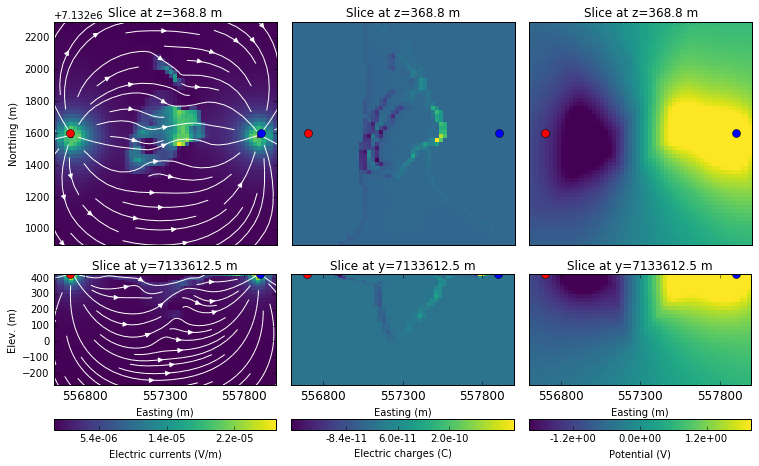

In [20]:
interact(lambda indz,indy: dataPanelPlot(indz,indy), indz=IntSlider(min=0, max=mesh.nCz-1,step=1, value=28), indy=IntSlider(min=0, max=mesh.nCy-1,step=1, value=31))

### Compute DC data

In [21]:
# Evaluate potential at Rx locations
obsdata = Survey.Data(survey, v=dobs)
Xx = 0.5*(Mx[:,0]+Nx[:,0]).reshape((23, 24), order="F")
Yx = Mx[:,1].reshape((23, 24), order="F")

### Visualize DC data

In [22]:
def vizdata(data, src, rx, rxcomponent="X", clim=None, title=None, figsave=None, ax=None, cb=True,cbOrient="vertical"):
    if ax is None:
        fig = plt.figure(figsize=(6.8, 5.5))
        ax = plt.subplot(111)

    temp = data[src, rx]
    if rxcomponent=="X":
        X = Xx.copy()
        Y = Yx.copy()
    else:
        X = Xy.copy()
        Y = Yy.copy()
    temp = temp.reshape(X.shape, order="F")
    if clim is not None:
        vmin, vmax = clim[0], clim[1]
        dat = ax.contourf(X, Y, temp, 20, clim=clim, vmin=vmin, vmax=vmax, cmap="plasma")
        ax.contour(X, Y, temp, 10, colors="k")
    else:
        vmin, vmax = temp.min(), temp.max()
        dat = ax.contourf(X, Y, temp, 20, cmap="plasma")
        ax.contour(X, Y, temp, 10, colors="k")
        
    if title is not None:
        ax.set_title(title)
    xmin, xmax = X.min(), X.max()
    ymin, ymax = Y.min(), Y.max()            
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.set_xticks(np.linspace(xmin, xmax, 3))
    ax.set_yticks(np.linspace(ymin, ymax, 3))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)            
    
    if cb:
        cb = plt.colorbar(dat, orientation=cbOrient, ticks=np.linspace(vmin, vmax, 3), format="%.1e")
        cb.set_label("Potential (V)")
        
    if figsave is not None:
        fig.savefig(figsave, dpi=200)
    return ax
    

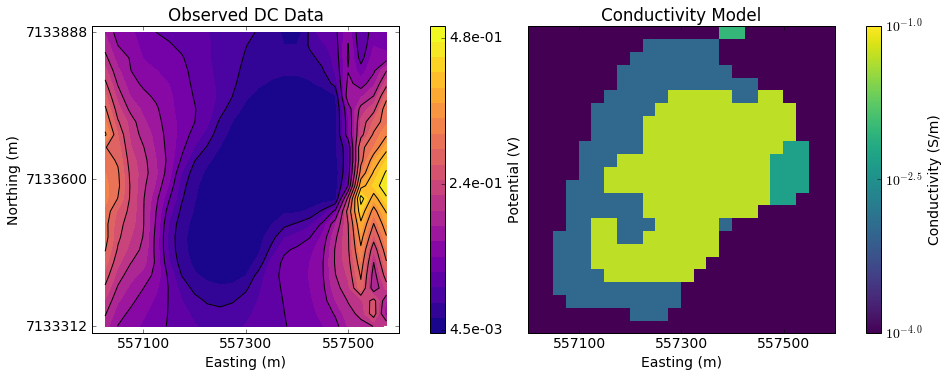

In [23]:
fig = plt.figure(figsize(11, 5.5))
xmin, xmax = -300+xc, 300+xc
ymin, ymax = -300+yc, 300+yc
indz = 28

matplotlib.rcParams['font.size'] = 14
# Axis label
x = np.linspace(xmin+100, xmax-100,3)

# DC observed data
ax1 = plt.subplot(1,1,1)
pos =  ax1.get_position()
ax1.set_position([pos.x0, pos.y0,  pos.width*0.5, pos.height])
ax1 = vizdata(obsdata, src1, rx_x, ax=ax1, rxcomponent="X", title="Observed DC Data", clim=(4.5e-3, 4.8e-1))
plt.gca().set_aspect('equal')
# ax1.set_title(("Slice at z=%.1f m")%(mesh.vectorCCz[indz]))
# ax1.xaxis.set_visible(False)
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)   
ax1.set_xticks(map(int, x))
ax1.set_xticklabels(map(str, map(int, x)),size=14)
ax1.set_xlabel('Easting (m)')
ax1.set_ylabel('Northing (m)')
ax1.set

# True conductivity model
ax2 = fig.add_axes([pos.x0+0.55, pos.y0,  pos.width, pos.height])
ax2,dat2 = viz(mesh, sigma, indz, airind, normal="Z", xc=xc, yc=yc, zc=zc, ax=ax2)
plt.gca().set_aspect('equal')
ax2.set_title(("Slice at z=%.1f m")%(mesh.vectorCCz[indz]))
ax2.yaxis.set_visible(False)
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(ymin, ymax)
ax2.set_xticks(map(int, x))
ax2.set_xticklabels(map(str, map(int, x)),size=14)
ax2.set_xlabel('Easting (m)')
ax2.set_title('Conductivity Model')

## Inverse problem

### Run inverse problem
Re-running the inverison will take a few minutes. Only uncomment the run statement below if you wish to re-run the inversion and see the output. Pickled results can be loaded below without re-running the inversion.

- Inversion script: https://github.com/simpeg/tutorials/blob/DCIP/notebooks/dcip/TKCExample_DCinv.py

In [24]:
# run TKCExample_DCinv.py

### Load inversion results

In [25]:
import pickle
# Load inversion results
DCresults_withdepth = pickle.load(open( "DCresults", "rb" ))
# print DCresults_withdepth.keys()

# Get inversion model
sigopt_withdepth = DCresults_withdepth['sigma_inv']

# Get predicted data
dpred = DCresults_withdepth['Pred']
preddata = Survey.Data(survey, v=dpred)

### Plot true and recovered conductivity models to assess how well anomalous structures are recovered.

In [26]:
def compareTrueRecoveredMod(indz,indy):
    fig = plt.figure(figsize(11, 8))
    vmin, vmax = -4, -1
    xmin, xmax = -500+xc, 500+xc
    ymin, ymax = -500+yc, 500+yc
    zmin, zmax = -500+zc, 0+zc
#     indz = 28
#     indy = 31
    # Axis label
    x = np.linspace(xmin+200, xmax-200,3)
    matplotlib.rcParams['font.size'] = 10

    # True Conductivity Model z-section
    ax1 = plt.subplot(1,1,1)
    pos =  ax1.get_position()
    ax1.set_position([pos.x0-0.1, pos.y0+0.3,  pos.width*0.5, pos.height*0.5])
    ax1,dat1 = viz(mesh, sigma, indz, airind, normal="Z", xc=xc,yc=yc,zc=zc, ax=ax1, cb=False, clim=(vmin, vmax))
    plt.gca().set_aspect('equal')
    ax1.set_title(("Slice at z=%.1f m")%(mesh.vectorCCz[indz]))
    ax1.xaxis.set_visible(False)
    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(ymin, ymax)    
    ax1.set_ylabel('Northing (m)')

    # True Conductivity Model y-section
    pos =  ax1.get_position()
    ax2 = fig.add_axes([pos.x0+0.0525, pos.y0 - 0.36,  pos.width*0.725, pos.height])
    ax2, dat2 = viz(mesh, sigma, indy, airind, normal="Y", xc=xc,yc=yc,zc=zc, ax=ax2, cb=False, clim=(vmin, vmax))
    plt.gca().set_aspect('equal')
    ax2.set_title(("Slice at y=%.1f m")%(mesh.vectorCCy[indy]))
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(zmin, zmax) 
    ax2.set_xticks(map(int, x))
    ax2.set_xticklabels(map(str, map(int, x)),size=12)
    ax2.set_xlabel('Easting (m)')
    ax2.set_ylabel('Elev. (m)')

    # DC Recovered Model z-section
    ax3 = fig.add_axes([pos.x0+0.3, pos.y0,  pos.width, pos.height])
    ax3,dat3 = ax = viz(mesh, sigopt_withdepth, indz, airind, normal="Z", xc=xc,yc=yc,zc=zc, ax=ax3, cb=False, clim=(vmin, vmax))
    plt.gca().set_aspect('equal')
    ax3.set_title(("Slice at z=%.1f m")%(mesh.vectorCCz[indz]))
    ax3.xaxis.set_visible(False)
    ax3.yaxis.set_visible(False)
    ax3.set_xlim(xmin, xmax)
    ax3.set_ylim(ymin, ymax)

    # DC Recovered Model y-section
    ax4 = fig.add_axes([pos.x0+0.3525, pos.y0 - 0.36,  pos.width*0.725, pos.height])
    ax4, dat4 = viz(mesh, sigopt_withdepth, indy, airind,  normal="Y", xc=xc,yc=yc,zc=zc, ax=ax4, cb=False, clim=(vmin, vmax))
    plt.gca().set_aspect('equal')
    ax4.set_title(("Slice at y=%.1f m")%(mesh.vectorCCy[indy]))
    ax4.yaxis.set_visible(False)
    ax4.set_xlim(xmin, xmax)
    ax4.set_ylim(zmin, zmax) 
    ax4.set_xticks(map(int, x))
    ax4.set_xticklabels(map(str, map(int, x)),size=12)
    ax4.set_xlabel('Easting (m)')

    pos =  ax4.get_position()
    cbarax = fig.add_axes([pos.x0-0.15 , pos.y0-0.01 ,  pos.width, pos.height*0.05])  ## the parameters are the specified position you set
    cb = fig.colorbar(dat4[0],cax=cbarax, orientation="horizontal", ax = ax4, ticks=np.linspace(vmin,vmax, 4), format="1.e%.f")
    cb.set_label("Conductivity (S/m)",size=12)

<function __main__.<lambda>>

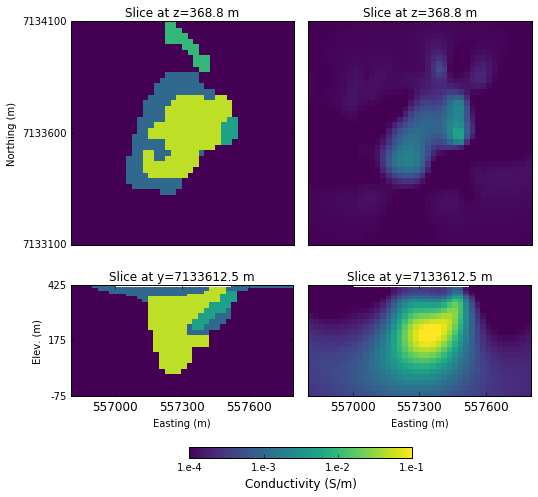

In [27]:
interact(lambda indz,indy: compareTrueRecoveredMod(indz,indy), indz=IntSlider(min=0, max=mesh.nCz-1,step=1, value=28), indy=IntSlider(min=0, max=mesh.nCy-1,step=1, value=31))

### Plot observed and predicted data to evaluate how well the recovered model fits the observed data.

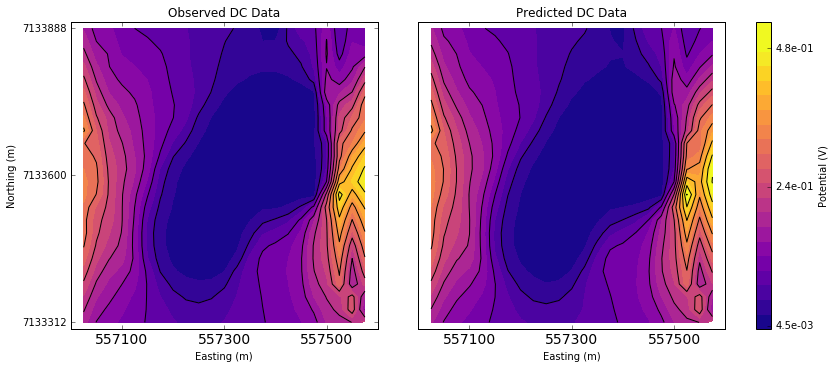

In [28]:
fig = plt.figure(figsize(11, 5.5))
xmin, xmax = -300+xc, 300+xc
ymin, ymax = -300+yc, 300+yc
indz = 28

# Axis label
x = np.linspace(xmin+100, xmax-100,3)

# DC observed data
ax1 = plt.subplot(1,1,1)
pos =  ax1.get_position()
ax1.set_position([pos.x0-0.4, pos.y0,  pos.width, pos.height])
ax1 = vizdata(obsdata, src1, rx_x, ax=ax1, rxcomponent="X", title="Observed DC Data", clim=(4.5e-3, 4.8e-1), cb=False)
plt.gca().set_aspect('equal')
# ax1.set_title(("Slice at z=%.1f m")%(mesh.vectorCCz[indz]))
# ax1.xaxis.set_visible(False)
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)   
ax1.set_xticks(map(int, x))
ax1.set_xticklabels(map(str, map(int, x)),size=14)
ax1.set_xlabel('Easting (m)')
ax1.set_ylabel('Northing (m)')

# DC Predicted data
ax2 = fig.add_axes([pos.x0, pos.y0,  pos.width, pos.height])
ax2 = vizdata(preddata, src1, rx_x, ax=ax2, rxcomponent="X", title="Predicted DC Data", clim=(4.5e-3, 4.8e-1))
plt.gca().set_aspect('equal')
ax2.yaxis.set_visible(False)
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(ymin, ymax)
ax2.set_xticks(map(int, x))
ax2.set_xticklabels(map(str, map(int, x)),size=14)
ax2.set_xlabel('Easting (m)')